In [25]:
import argparse
import json
import logging
import os
import math
import numpy as np
import torch
import torch.utils.data as data
from tqdm import tqdm

import optim
# from config import config_args
from datasets.hc_dataset import HCDataset
from datasets.loading import load_data
from model.hyphc import HypHC
from utils.metrics import dasgupta_cost
from utils.training import add_flags_from_config, get_savedir

import networkx as nx

import matplotlib.pyplot as plt
from mst import mst

from utils.poincare import project,hyp_dist_djj
from utils.lca import hyp_lca
from utils.math import arctanh, tanh, arcosh

from utils.visualization import plot_tree_from_leaves,plot_geodesic

In [26]:
np.random.seed(1234)
torch.manual_seed(1234)


In [27]:
from utils.lca import hyp_lca

def hyp_lca_numpy(x, y):
    """Computes the hyperbolic LCA in numpy."""
    x = torch.from_numpy(x).view((1, 2))
    y = torch.from_numpy(y).view((1, 2))
    lca = hyp_lca(x, y, return_coord=True)
    return lca.view((2,)).numpy()
def is_leaf(tree, node):
    """check if node is a leaf in tree."""
    return len(list(tree.neighbors(node))) == 0
def complete_tree(tree, leaves_embeddings):
    """Get embeddings of internal nodes from leaves' embeddings using LCA construction."""

    def _complete_tree(embeddings, node):
        children = list(tree.neighbors(node))
        if len(children) == 2:
            left_c, right_c = children
            left_leaf = is_leaf(tree, left_c)
            right_leaf = is_leaf(tree, right_c)
            if left_leaf and right_leaf:
                pass
            elif left_leaf and not right_leaf:
                embeddings = _complete_tree(embeddings, right_c)
            elif right_leaf and not left_leaf:
                embeddings = _complete_tree(embeddings, left_c)
            else:
                embeddings = _complete_tree(embeddings, right_c)
                embeddings = _complete_tree(embeddings, left_c)
            embeddings[node] = hyp_lca_numpy(embeddings[left_c], embeddings[right_c])
        return embeddings

    n = leaves_embeddings.shape[0]
    tree_embeddings = np.zeros((2 * n - 1, 2))
    tree_embeddings[:n, :] = leaves_embeddings
    root = max(list(tree.nodes()))
    tree_embeddings = _complete_tree(tree_embeddings, root)
    return tree_embeddings

In [77]:
x, y_true, similarities = load_data('../../../cityu/HypHC/data/4_8/4_8.data',1,514,0)
dataset = HCDataset(x, y_true, similarities, num_samples=50000)
dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
model = HypHC(dataset.n_nodes, 2, 5e-2, 5e-2 ,0.999)
model.to("cpu")
Optimizer = getattr(optim, 'RAdam')
optimizer = Optimizer(model.parameters(),0.0005)
counter = 0

Generating all pairs superset


In [81]:
train(model,dataloader,optimizer,similarities,1)

100%|██████████| 1563/1563 [00:58<00:00, 26.62ex/s, loss=1.315599] 

	 Epoch 0 | average train loss: 1.295420
Optimization finished.


In [80]:
def train(model,dataloader,optimizer,similarities,epoches):
    best_cost = np.inf
    best_model = None
    for epoch in range(epoches):
        model.train()
    total_loss = 0.0
    with tqdm(total=len(dataloader), unit='ex') as bar:
        for step, (triple_ids, triple_similarities) in enumerate(dataloader):
            # triple_ids = triple_ids.cuda()
            # triple_similarities = triple_similarities.cuda()
            loss = model.loss(triple_ids, triple_similarities)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bar.update(1)
            bar.set_postfix(loss=f'{loss.item():.6f}')
            total_loss += loss
    total_loss = total_loss.item() / (step + 1.0)
    print("\t Epoch {} | average train loss: {:.6f}".format(epoch, total_loss))

    # keep best embeddings
    if (epoch + 1) % 1 == 0:
        model.eval()
        tree = model.decode_tree(fast_decoding=1)
        cost = dasgupta_cost(tree, similarities)
        logging.info("{}:\t{:.4f}".format("Dasgupta's cost", cost))
        if cost < best_cost:
            counter = 0
            best_cost = cost
            best_model = model.state_dict()
        else:
            counter += 1
            if counter == 20:
#                 logging.info("Early stopping.")
                return

    # anneal temperature
    if (epoch + 1) % 30 == 0:
        model.anneal_temperature(0.5)
#         logging.info("Annealing temperature to: {}".format(model.temperature))
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5
            lr = param_group['lr']
        print("Annealing learning rate to: {}".format(lr))

    print("Optimization finished.")
    if best_model is not None:
        # load best model
        model.load_state_dict(best_model)



In [82]:
model.eval

<bound method Module.eval of HypHC(
  (embeddings): Embedding(21, 2)
)>

In [31]:
def dist(x,y):
    return arcosh(1+ 2*( (x-y).norm(dim=-1, p=2, keepdim=True))/((1- y.norm(dim=-1, p=2, keepdim=True))*(1- x.norm(dim=-1, p=2, keepdim=True))));
def plot_tree_from_leaves_djj_1(ax, tree, leaves_embeddings, labels, color_seed=1234):
    """Plots a tree on leaves embeddings using the LCA construction."""
    circle = plt.Circle((0, 0), 20.0, color='r', alpha=0.1)
    ax.add_artist(circle)
    n = leaves_embeddings.shape[0]
    embeddings = complete_tree(tree, leaves_embeddings)
    colors = get_colors(labels, color_seed)
    ax.scatter(embeddings[:n, 0]*20, embeddings[:n, 1]*20, c=colors, s=50, alpha=0.6)
    
    for n1, n2 in tree.edges():
        x1 = embeddings[n1]
        x2 = embeddings[n2]
        plot_geodesic(x1, x2, ax)
    # ax.set_xlim(-1.05, 1.05)
    # ax.set_ylim(-1.05, 1.05)
    ax.axis("off")
    return ax
def sl_np_mst_ij(xs, S):
    xs = project(xs).detach().cpu()

    xs0 = xs[None, :, :]
    xs1 = xs[:, None, :]
    sim_mat = S(xs0, xs1)  # (n, n)
    similarities = sim_mat.numpy()
    n = similarities.shape[0]
    similarities=similarities.astype('double')
    ij, _ = mst.mst(similarities, n)
    return ij
sim_fn = lambda x, y: torch.sum(x * y, dim=-1)
n=len(x);

In [32]:
d = model.normalize_embeddings(model.embeddings.weight.data)
d = project(d).detach().cpu()
ijs = sl_np_mst_ij(d,sim_fn)

/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_28087/1330637655.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ij, _ = mst.mst(similarities, n)


In [33]:
class  UnionFind:
    
    def __init__(self, n , pos , c):
        self.n = n
        self.pos = pos
        self.c = c
        self.parent = [i for i in range(n)]
        self.rank = [0 for i in range(n)]
        self.vis = [0 for i in range(2*n-1)]
        self.vis2 = [0 for i in range(2*n-1)]
        self.mer = [-1 for i in range(2*n-1)]
        self._next_id = n
        self._tree = [-1 for i in range(2*n-1)]

        self._id = [i for i in range(n)]

    def _find(self, i):
        if self.parent[i] == i:
            return i
        else:
            self.parent[i] = self._find(self.parent[i])
            return self.parent[i]

    def find(self, i):
        if (i < 0) or (i > self.n):
            raise ValueError("Out of bounds index.")
        return self._find(i)

    def union(self,  i,  j, k=True):
        root_i = self._find(i)
        root_j = self._find(j)
        if root_i == root_j:
            return False
        else:
            
            if self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
                if(k):
                    self._build(root_j, root_i)
                
            elif self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
                if(k):
                    self._build(root_i, root_j)
                
            else:
                
                self.parent[root_j] = root_i
                self.rank[root_i] += 1
                if(k):
                    self._build(root_i, root_j)
                
            return True


    def merge(self,ij):
        for k in range(ij.shape[0]):
            a=ij[k,0];
            b=ij[k,1];
            if(self.mer[a]!=-1):
                a=self.mer[a];
            if(self.mer[b]!=-1):
                b=self.mer[b];
            self.union(a, b)

    def  _build(self, i, j):
#         print(self._tree[0],"----")
#         if(dist(self.pos[self._id[i]],self.pos[self._id[j]])<self.c):
            
            
#             print(i,j,'-',self._id[i],self._id[j]);
#             self.vis[self._id[i]]=1;
#             self.vis[self._id[j]]=1;
                
#             t=np.array(self.pos).tolist()
#             new = np.array(hyp_lca(self.pos[self._id[i]],self.pos[self._id[j]])).tolist()
#             t.append(new);
#             self.pos=torch.tensor(t)
#             self.pos[self._id[i]] = torch.tensor(new);
#             self.pos[self._id[j]] = torch.tensor(new);
            
#             self.search(self._id[i]);
#             self.search(self._id[j]);

#             self._tree[self._id[i]] = self._next_id
#             self._tree[self._id[j]] = self._next_id
#             self._id[i] = self._next_id
#             self._next_id += 1
            
#         else:
            
#             t=np.array(self.pos).tolist()
#             new = np.array(hyp_lca(self.pos[self._id[i]],self.pos[self._id[j]])).tolist()
#             t.append(new);
#             self.pos=torch.tensor(t)
#             self._tree[self._id[i]] = self._next_id
#             self._tree[self._id[j]] = self._next_id
#             self._id[i] = self._next_id
#             self._next_id += 1
        self.vis2[i]=1;
        self.vis2[j]=1;
        
        t=np.array(self.pos).tolist()
        new = np.array(hyp_lca(self.pos[self._id[i]],self.pos[self._id[j]])).tolist()
        t.append(new);
        self.pos=torch.tensor(t)
        
        self._tree[self._id[i]] = self._next_id
        self._tree[self._id[j]] = self._next_id
        self._id[i] = self._next_id
        self.check(i);
        self._next_id += 1

    def search(self,k):
#         for i in range(len(self.parent)):
#             if(self.parent[i]==k):
#                 self.parent[i]=self._next_id;
#         print(k==-1)

        for i in range(len(self._tree)):
            if(self.vis[i]):
                continue;            
            if(self._tree[i]==k):
                print("sear")
                self._tree[i]=self._next_id;  
                
        for i in range(len(self._id)):
            if(self.vis[i]):
                continue;
            if(self._id[i]==k):
                print("Sear")
                self._id[i]=self._next_id;  
                
    def check(self,t):
        minnum=math.inf
        minns=None;
        for i in range(self.n):
            if(self.vis[i] or self.vis2[i]):
                continue;
            distance = dist(self.pos[i],self.pos[-1]);
            if(distance<self.c and distance < minnum):
                minnum = distance
                minns = i;
                
#                 print("merge {} in {}".format(i,t))
#                 self.parent[i]=t;
#                 self.vis[i]=1;
#                 self.search(i);
        if(minns != None):
            print("merge {} in {}".format(minns,self._next_id))
            self.vis[minns]=1;
            self.rank[minns]=-1;
            self.pos[minns] = self.pos[-1]
#             self.search(minns);
            self.mer[minns]=t;
            self.mer[self._next_id] = minns;
#             self.union(t,minns,False);
        
    def parent(self):
        return [self.parent[i] for i in range(self.n)]

    def tree(self):
        return [self._tree[i] for i in range(len(self._tree))]
    

In [43]:
n=len(x)
uf = UnionFind(n,d,1)
uf.merge(ijs)

merge 5 in 21
merge 15 in 22
merge 19 in 23
merge 12 in 24
merge 18 in 25
merge 8 in 26
merge 10 in 27


21 pass
22 pass
23 pass
24 pass
25 pass
26 pass
27 pass


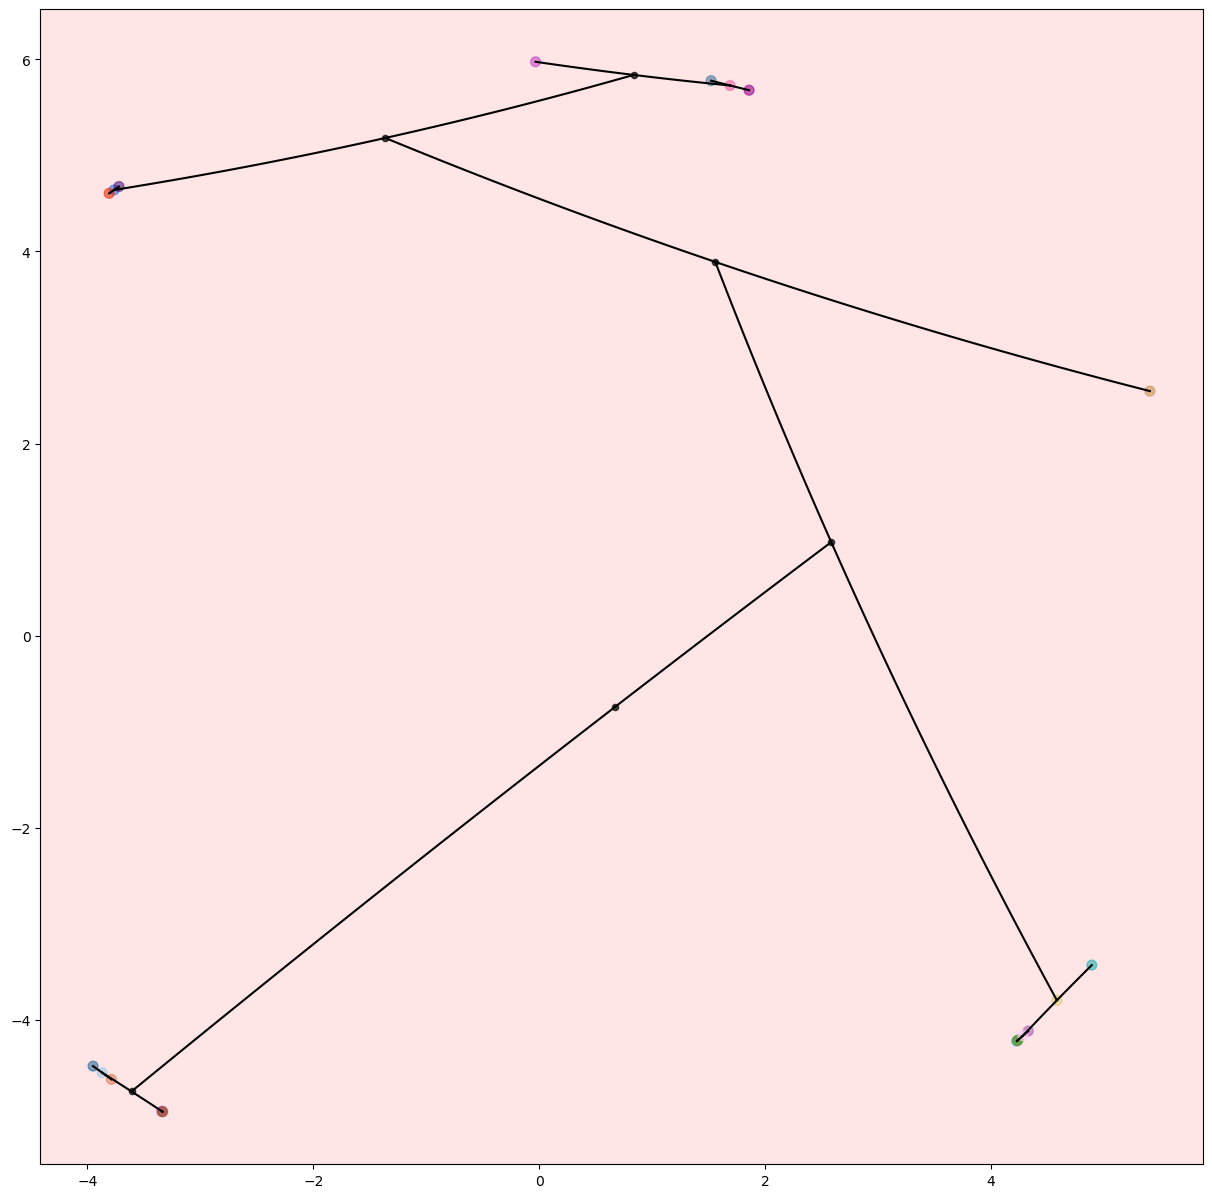

In [69]:
count=0
def get_colors(y, color_seed=1234):
    """random color assignment for label classes."""
    np.random.seed(color_seed)
    colors = {}
    for k in np.unique(y):
        r = np.random.random()
        b = np.random.random()
        g = np.random.random()
        colors[k] = (r, g, b)
    return [colors[k] for k in y]

tree = nx.DiGraph()
for i, j in enumerate(uf.tree()[:-1]):
    if(j!=-1):
        tree.add_edge(j, i)
        
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
circle = plt.Circle((0, 0), 20.0, color='r', alpha=0.1)
ax.add_artist(circle)

n = len(d)
embeddings = np.array(uf.pos)
# for i in range(len(embeddings)):
#     if(np.isnan(embeddings[i][0]) or embeddings[i][0] + embeddings[i][1] == 0):
#         embeddings[i] = embeddings[i-1];
#     pass;
# print(embeddings)
where_are_NaNs = np.isnan(embeddings)
embeddings[where_are_NaNs] = 0
vis = uf.vis
# xlist=[]
# ylist=[]
# labels=[]

# for i in range(n):
#     if(uf.vis[i]!=1):
#         xlist.append(embeddings[i,0]*20);
#         ylist.append(embeddings[i,1]*20);
#         labels.append(y_true[i]);
# # colors = get_colors(labels, 1234)
colors = get_colors(y_true, 1234)

# ax.scatter(xlist, ylist, c=colors, s=50, alpha=0.6)

ax.scatter(embeddings[:n, 0]*20, embeddings[:n, 1]*20, c=colors, s=50, alpha=0.6)

for i in range(len(embeddings)):
    if(i<n):
        continue;
    if(uf.mer[i]!=-1):
        print(i,'pass')
        pass;
    else:
        ax.scatter(embeddings[i][0]*20,embeddings[i][1]*20,color='black',s=20,alpha=0.7)

    

for n1, n2 in tree.edges():
#     if(uf.vis[n1]== 1 or uf.vis[n2]== 1 ):
# #         print("1")
#         pass
#     else:
#         x1 = embeddings[n1]
#         x2 = embeddings[n2]
# #         if(n1>=n):
# #             if(uf.mer[n1]!=-1):
# #                 pass;
# #             else:
# #                 count+=1;
# #         if(n2>n):
# #             if(uf.mer[n1]!=-1):
# # # 
# #                 pass;
# #             else:
# # #                 ax.scatter(x2[0]*20,x2[1]*20,color='black',s=20,alpha=0.7)
# #                 count+=1
    
    
#         plot_geodesic(x1, x2, ax)
# #         print(x1,x2,n1,n2)
# #         break
#         pass

#     ax.axis("off")
    x1 = embeddings[n1];
    x2 = embeddings[n2];
    plot_geodesic(x1,x2,ax)


In [36]:
np.save("./dataxy.npy",embeddings)

In [37]:
np.save("./datalink.npy",list(tree.edges()))